In [463]:
%matplotlib inline
import re
import numpy as np
import pandas as pd

from IPython.display import display, HTML
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime

In [476]:
def extract(string, key, dtype):
    if dtype is bool:
        return True if re.search(' {}=((True)|(False)) '.format(key), string).group(1) == 'True' else False
    if dtype is float:
        return float(re.search(' {}=(\d+(\.\d+)?(?:[eE][+\-]?\d+)?)'.format(key), string).group(1))
    if dtype is int:
        return float(re.search(' {}=(\d+) '.format(key), string).group(1))

def get_result_metrics(filepath):
    # get lines with results
    lines = []
    marker = 'Got result: '
    with open(filepath) as f:
        for line in f.readlines():
            if marker in line:
                lines.append(line.split(marker, 1)[1])
    
    # extract metrics
    runs = []
    for run in lines:
        if not extract(run, 'success', bool):
            continue
        data = {
            'time_created': extract(run, 'time_created', float),
            'time_input_received': extract(run, 'time_input_received', float),
            'time_compute_started': extract(run, 'time_compute_started', float),
            'time_result_sent': extract(run, 'time_result_sent', float),
            'time_result_received': extract(run, 'time_result_received', float),
            'time_running': extract(run, 'time_running', float),
            'time_serialize_inputs': extract(run, 'time_serialize_inputs', float),
            'time_deserialize_inputs': extract(run, 'time_deserialize_inputs', float),
            'time_serialize_results': extract(run, 'time_serialize_results', float),
            'time_deserialize_results': extract(run, 'time_deserialize_results', float),
            'time_result_received': extract(run, 'time_result_received', float),
            'time_async_resolve_proxies': extract(run, 'time_async_resolve_proxies', float),
        }
        

        
        data['client_to_method_server'] = data['time_input_received'] - (
                data['time_created'] + data['time_serialize_inputs'])
        data['worker_to_method_server'] = data['time_result_sent'] - (
                data['time_compute_started'] + data['time_running'] + 
                data['time_deserialize_inputs'] + data['time_serialize_results'] +
                data['time_async_resolve_proxies'])
        data['method_server_to_client'] = data['time_result_received'] - (
                data['time_result_sent'] + data['time_deserialize_results'])
        data['time_serialization'] = sum(data[key] for key in data if 'serialize' in key)
        data['time_created_to_result_received'] = data['time_result_received'] - data['time_created']
        
        runs.append(data)
    
    return pd.DataFrame(runs)

def aggregate_runs(run_paths):
    data = []
    for path in run_paths:
        results = pd.Series({'path': path})

        with open(path) as f:
            first_line = f.readline()
            timestamp = first_line.split(' - ')[0]
            value_server = True if re.search('use_value_server=(.+),', first_line).group(1) == 'True' else False
            results['value_server'] = value_server
            results['task_count'] = int(re.search('task_count=(\d+),', first_line).group(1))
            results['task_input_size'] = int(re.search('task_input_size=(\d+),', first_line).group(1))
            results['task_interval'] = float(re.search('task_interval=(\d+(\.\d+)?(?:[eE][+\-]?\d+)?),', first_line).group(1))
            results['task_output_size'] = int(re.search('task_output_size=(\d+),', first_line).group(1))
            results['time_start'] = datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S,%f").timestamp()
            
            to_proxy_times = []
            for line in f.readlines():
                if 'to_proxy_time=' in line:
                    to_proxy_times.append(extract(line, 'to_proxy_time', float))
            results['to_value_server_time'] = np.median(to_proxy_times) if len(to_proxy_times) > 0 else 0

        function_results = get_result_metrics(path)
        results['n_tasks'] = len(function_results.index)
        results['total'] = None
        results = pd.concat([results, function_results.median()])
                
        data.append(results)
        
    return pd.concat(data, axis=1).T

In [471]:
cols = ['client_to_method_server', 'worker_to_method_server', 'method_server_to_client', 'time_serialization', 'to_value_server_time', 'time_async_resolve_proxies', 'time_running', 'total']
ind = np.arange(len(cols))
width = 0.35

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_running,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/full_test_reuse_30s_50x50/2021-02-16_23-0...,False,50,50,15,0,1.61352e+09,0,50,None,...,0.01046,0.000161834,0.000773301,0.000870031,0.000146902,0.00161815,0.00515652,0.00165379,0.00198728,0.036919
1,runs/full_test_reuse_30s_50x50/2021-02-16_23-2...,True,50,50,15,0,1.61352e+09,0.000254869,50,None,...,0.0103267,5.00115e-05,0.000170711,0.000341923,7.09424e-05,0.000748515,0.00513208,0.000612259,0.000636162,0.0340531


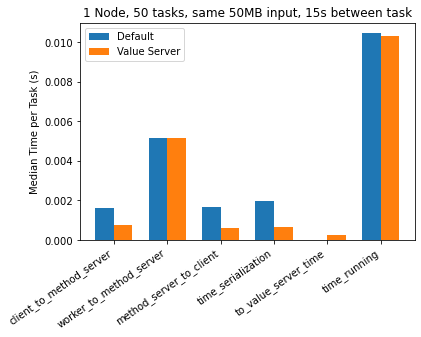

In [461]:
rundir = 'runs/full_test_reuse_30s_50x50/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['time_running'] = results['time_running']
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

width = 0.35
fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 50 tasks, same 50MB input, 15s between task')
plt.ylabel('Median Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_running,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/full_test_unique_30s_50x50/2021-02-16_23-...,False,50,50,15,0,1.61352e+09,0,50,None,...,0.0103396,0.000160891,0.000770695,0.000864466,0.000153352,0.00155175,0.00498819,0.0016799,0.00200739,0.0375686
1,runs/full_test_unique_30s_50x50/2021-02-17_00-...,True,50,50,15,0,1.61352e+09,0.000261426,50,None,...,0.0105738,5.2989e-05,0.000165901,0.000356088,7.4301e-05,0.000786424,0.00533581,0.000629187,0.000644933,0.0317279


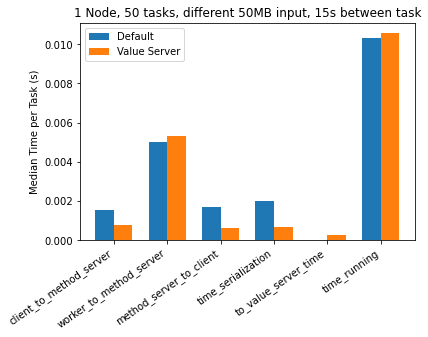

In [462]:
rundir = 'runs/full_test_unique_30s_50x50/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['time_running'] = results['time_running']
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

width = 0.35
fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 50 tasks, different 50MB input, 15s between task')
plt.ylabel('Median Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()

### Add async resolve time to correct worker->method server

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,time_async_resolve_proxies,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/full_test_unique_30s_50x50_v2/2021-02-19_...,False,50,50,15,0,1.61375e+09,0,50,0.020379,...,0.000158156,0.000768916,0.000865401,0.000150943,3.892e-05,0.00159407,0.00480425,0.00166404,0.00198548,0.0363075
1,runs/full_test_unique_30s_50x50_v2/2021-02-19_...,True,50,50,15,0,1.61375e+09,0.000622511,50,0.019060,...,3.9408e-05,0.000171691,0.000356231,5.86935e-05,0.0017213,0.000837445,0.00424087,0.000621676,0.000633146,0.034098


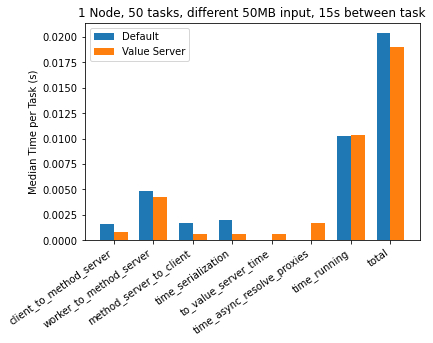

In [475]:
rundir = 'runs/full_test_unique_30s_50x50_v2/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

width = 0.35
fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 50 tasks, different 50MB input, 15s between task')
plt.ylabel('Median Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,time_async_resolve_proxies,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/full_test_reuse_30s_50x50_v2/2021-02-19_1...,False,50,50,15,0,1.61375e+09,0,50,0.020597,...,0.000168007,0.000769751,0.000874006,0.000155534,3.94149e-05,0.0016371,0.00488138,0.00166535,0.00200415,0.038378
1,runs/full_test_reuse_30s_50x50_v2/2021-02-19_1...,True,50,50,15,0,1.61376e+09,0.000253439,49,0.018269,...,5.1477e-05,0.00016859,0.000352641,6.7072e-05,0.00131697,0.000860214,0.00417614,0.0006814,0.000635739,0.037358


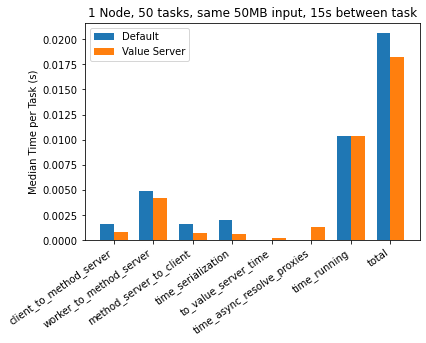

In [478]:
rundir = 'runs/full_test_reuse_30s_50x50_v2/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

width = 0.35
fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 50 tasks, same 50MB input, 15s between task')
plt.ylabel('Median Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()

### No async resolving

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,time_async_resolve_proxies,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/full_test_reuse_30s_50x50_v3/2021-02-19_1...,True,50,50,15,0,1.61376e+09,0.000239253,50,0.016885,...,4.99175e-05,0.000161641,0.000355128,7.03544e-05,5.99946e-07,0.000888228,0.00394154,0.000656724,0.000631063,0.029606
1,runs/full_test_reuse_30s_50x50_v3/2021-02-19_1...,False,50,50,15,0,1.61376e+09,0,50,0.020671,...,0.000162563,0.000770146,0.000867402,0.000150792,6.65023e-07,0.00152493,0.00519514,0.00162077,0.00198027,0.0457946


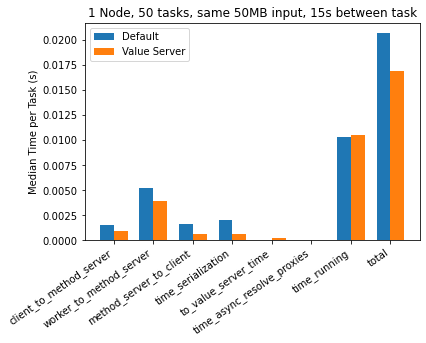

In [481]:
rundir = 'runs/full_test_reuse_30s_50x50_v3/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

width = 0.35
fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 50 tasks, same 50MB input, 15s between task')
plt.ylabel('Median Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()

### Fix async_resolve proxy to be noop if proxy is already resolved
### Fix pickling Factory instance while calling async_resolve on it

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,time_async_resolve_proxies,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/full_test_reuse_30s_50x50_v4/2021-02-19_1...,False,50,50,15,0,1.61376e+09,0,50,0.020644,...,0.000164585,0.000774555,0.000877382,0.000154414,4.00501e-05,0.00167227,0.00495613,0.00167787,0.00200282,0.0457135
1,runs/full_test_reuse_30s_50x50_v4/2021-02-19_1...,True,50,50,15,0,1.61376e+09,0.000274539,50,0.018555,...,4.9431e-05,0.000154901,0.000342592,7.3905e-05,0.00137128,0.000807524,0.00443864,0.000722408,0.000621784,0.032939


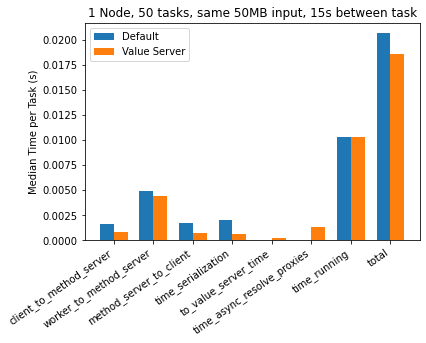

In [484]:
rundir = 'runs/full_test_reuse_30s_50x50_v4/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

width = 0.35
fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 50 tasks, same 50MB input, 15s between task')
plt.ylabel('Median Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()

### Notes
- When inputs are same for tasks, async_resolve is slower because of overhead of making new thread to get object from value server when the object is already cached locally
- Above plot: total time value server is 10.1% faster

### Custom LRU Cache
- Should fix above issue with creating separate threads to retrieve a cached object
- Now we are 17.4% faster with value server for reused inputs and 6.2% for unique inputs

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,time_async_resolve_proxies,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/full_test_reuse_30s_50x50_v5/2021-02-19_2...,False,50,50,15,0,1.61377e+09,0,50,0.020623,...,0.000172649,0.000781115,0.000876736,0.000154568,4.035e-05,0.00165117,0.00499177,0.00163746,0.00202765,0.0386125
1,runs/full_test_reuse_30s_50x50_v5/2021-02-19_2...,True,50,50,15,0,1.61377e+09,0.000262976,50,0.017030,...,4.52335e-05,0.000155446,0.000317858,7.11029e-05,9.48155e-05,0.000802755,0.00427973,0.000686169,0.000608673,0.0326051


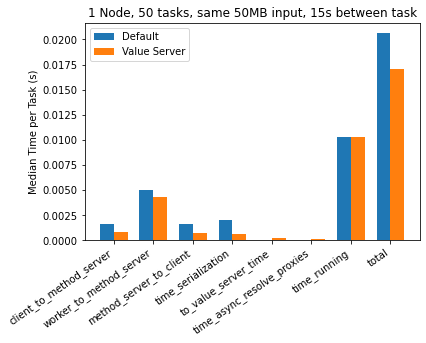

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,time_async_resolve_proxies,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/full_test_unique_30s_50x50_v3/2021-02-19_...,True,50,50,15,0,1.61377e+09,0.000666738,50,0.019194,...,3.74116e-05,0.000160846,0.000333928,6.4894e-05,0.00201655,0.000828624,0.0040617,0.00070858,0.000611063,0.0313314
1,runs/full_test_unique_30s_50x50_v3/2021-02-19_...,False,50,50,15,0,1.61377e+09,0,50,0.020464,...,0.000161843,0.000775527,0.000898502,0.00015447,4.0765e-05,0.00164902,0.00474882,0.0017364,0.00200318,0.0397825


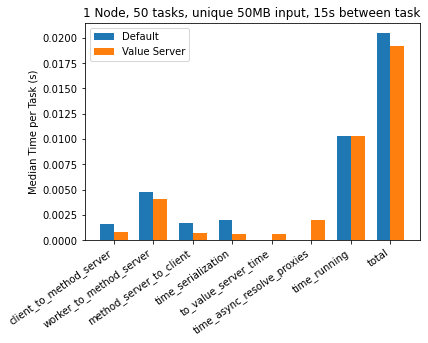

In [489]:
rundir = 'runs/full_test_reuse_30s_50x50_v5/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

width = 0.35
fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 50 tasks, same 50MB input, 15s between task')
plt.ylabel('Median Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()

rundir = 'runs/full_test_unique_30s_50x50_v3/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['total'] = results[cols].sum(axis=1)
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

width = 0.35
fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 50 tasks, unique 50MB input, 15s between task')
plt.ylabel('Median Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()